# Задание 10

In [57]:
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from community import best_partition
import networkx as nx
from sklearn.cluster import spectral_clustering

In [28]:
def draw_(Gk, pos, metrics, rescale_metrics=True):
    def rescale_log(weigths_list):
        cutoff = 1e-20
        for _ in range(len(weigths_list)):
            if weigths_list[_] < cutoff:
                weigths_list[_] = cutoff
        return 1/(np.log(np.array(weigths_list)))
    if rescale_metrics:
        metrics = rescale_log(metrics)
        
#     fig, ax = plt.figure(figsize=(10,20))
    norm = 500/np.max(metrics)
    options_n = {
    'node_color': [v * norm for v in metrics],
    'node_size': np.mean(metrics) * norm/2 * np.ones_like(metrics),
    'cmap': 'PiYG',
    'with_labels': False
    }
    options_e = {
    'line_color': 'grey',
    'linewidths': 0.5,
    'width': 0.5
    }
    nodes = nx.draw_networkx_nodes(G, pos, **options_n)
    nodes.set_edgecolor('grey')
    nx.draw_networkx_edges(G, pos, **options_e)

### 1.  Спектральные методы выделения сообществ (3 балла)
Будем работать с маленькой сетью социального взаимодействия среди [дельфинов](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.174.3721&rep=rep1&type=pdf). 
* разбейте сеть на два сообщества по собственному вектору матрицы Лапласа;
* разбейте сеть на два сообщества по собственному вектору матрицы модулярности;


Одинаковы ли эти разбиения? 
(Сделайте симпатичную визуализацию для наглядности) 

In [29]:
G = nx.read_edgelist('../data/soc-dolphins.txt', nodetype=int)

In [65]:
A = nx.adjacency_matrix(G).todense().astype(np.float64)
L = nx.laplacian_matrix(G).todense().astype(np.float64)

In [ ]:
def cluster(M):
    vals, vecs = np.linalg.eig(L)
    vecs = vecs[:,np.argsort(vals)]
    vals = vals[np.argsort(vals)]
    clusters = vecs[:,1] > 0
    clusters = np.array(clusters.astype(int)).flatten()
    return clusters

In [49]:
pos = nx.nx_pydot.graphviz_layout(G, prog='neato')

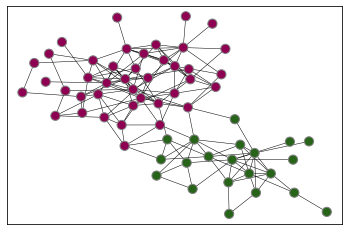

In [51]:
L = nx.laplacian_matrix(G).todense().astype(np.float64)
lap_partition = cluster(L)
draw_(G, pos, lap_partition, False)

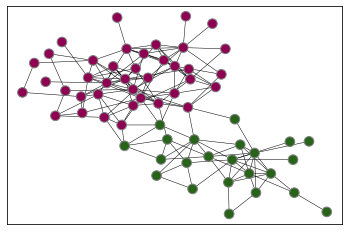

In [56]:
init_part = dict(zip(list(G.nodes()), cluster(L)))
mod_partition = [p for n, p in best_partition(G, init_part).items()]
draw_(G, pos, mod_partition, False)

### 2. Label propagation (3 балла)
Реализуйте алгоритм [Label propagation](https://en.wikipedia.org/wiki/Label_propagation_algorithm):

* в начальный момент времени всем вершинам ставится в соответствие отдельное сообщество.
* Каждая вершина в графе определяется в то сообщество, которому принадлежит большинство
    его соседей. Если же таких сообществ несколько, то выбирается случайно одно из
    них. Из-за случайности важно на каждой итерации изменять порядок обхода вершин. 
* Алгоритм заканчивает работу, когда нечего изменять: все вершины относятся к тем сообществам, что
    и большинство их соседей.
    
Какие сообщества у дельфинов выделяет ваш алгоритм, сравните со спектральными методами. 

In [103]:
def LabelPropagation(T, Y, diff, max_iter, labelled):
    Y_init = Y
    Y1 = Y
    
    n=0
    current_diff = 2**10
    
    while current_diff > diff or n < max_iter:
        
        current_diff = 0.0
        Y0 = Y1

        Y1 = T*Y0
        for i in range(Y_init.shape[0]):
            if i in labelled:
                for j in range(Y_init.shape[1]):
                    if i!=j:
                        Y1.A[i][j] = Y_init.A[i][j]
        
        for i in range(Y1.shape[0]):
            for j in range(Y1.shape[1]):
                current_diff += abs(Y1.A[i][j] - Y0.A[i][j])
        
        n += 1
        
    return Y1

In [104]:
D = np.identity(G.number_of_nodes())*np.array([d for n, d in G.degree()])
Dinv = np.linalg.inv(D)

In [110]:
_ = np.array([np.random.choice([0, 1]) for _ in range(G.number_of_nodes())]).reshape(-1,1)
Y = np.matrix(np.hstack((_,1-_)))
del _

In [114]:
LabelPropagation(Dinv*A, Y,  0.001, 1000, [0,1])

matrix([[0.99999933, 1.        ],
        [1.        , 0.99999601],
        [0.9999991 , 0.99999472],
        [0.99999917, 0.99999476],
        [0.9999991 , 0.99999454],
        [0.99999927, 0.99999631],
        [0.99999923, 0.99999597],
        [0.9999983 , 0.99999199],
        [0.99999851, 0.99999279],
        [0.99999861, 0.99999321],
        [0.99999841, 0.99999241],
        [0.99999843, 0.99999247],
        [0.99999891, 0.99999446],
        [0.99999886, 0.99999398],
        [0.99999832, 0.99999206],
        [0.9999984 , 0.99999235],
        [0.99999916, 0.99999667],
        [0.99999904, 0.99999513],
        [0.99999905, 0.99999537],
        [0.99999897, 0.99999449],
        [0.99999901, 0.99999448],
        [0.99999899, 0.99999441],
        [0.99999901, 0.99999467],
        [0.99999899, 0.99999461],
        [0.99999825, 0.99999177],
        [0.99999823, 0.99999173],
        [0.99999826, 0.99999183],
        [0.99999823, 0.9999917 ],
        [0.9999983 , 0.99999195],
        [0.999

### 3.  Тестирование алгоритмов на блочно-стохастических сетях (3 балла)
Будем тестировать алгоритмы выделения сообществ на сетях, состоящих из двух блоков равного размера $N$ с плотностью внутри блока $p_{in}$ и вероятностью связывания между вершинами разных блоков $p_{out}$. 
Пусть $f$ - доля вершин, которые были верно классифицированы алгоритмом. 
Постройте зависимость $f$ от параметра $\mu=\frac{p_{out}}{p_{in}+p_{out}}$ для разных алгоритмов выделения сообществ (на ваше усмотрение).

Для моделирования используйте фиксированное значение $p_{in}$ и варьируйте $p_{out}$. Например, $p_{in}=0.3$, $p_{out} \in \left[0,0.3\right]$

In [4]:
import community as co # алгоритм Лювена

### 4. Перколяция $k$- клик (треугольников) ( 3 балла)

* напишите функцию вычисляющую наибольший подграф, состоящий из смежных треугольников. Треугольники называются смежными, если они имеют общую сторону (две общие вершины). Назовем такой подграф перколяционным кластером. 

* постройте зависимость числа вершин перколяционного кластера от вероятности связи в случайном графе Эрдеша-Реньи. 


Обратите внимание, мы строили такую зависимость для гигантской компоненты, т.е. для перколяции по $k=2$ кликам. 
Порог перколяции по треугольникам определяется:
$$
p_{c}=\frac{1}{\sqrt{2N}}
$$